In [1]:
import pandas as pd
import numpy as np
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

In [2]:
# Definir las rutas a los directorios donde están los archivos CSV
directory = 'path'

# Función para cargar los datos de una temporada
def load_data(directory):
    data = {}
    if os.path.exists(directory):
        df = pd.read_csv(directory)
        #print(df)
        # Verificar que todas las columnas esperadas estén presentes
        expected_columns = ['Year','Driver', 'LapTime', 'LapNumber']
        if all(col in df.columns for col in expected_columns):
            data = df
        else:
            print("Advertencia: El archivo no tiene todas las columnas esperadas.")
        print("Carga exitosa")
    else:
        print(f"Archivo no encontrado: {directory}")
    return data

# Cargar datos de 2024 y 2025
data = load_data(directory)

print(data.head())

Carga exitosa
   Year Driver        LapTime  LapNumber
0  2018    VER   00:01:29.374        1.1
1  2019    VER   00:01:29.579        1.1
2  2019    VER   00:01:29.143        2.1
3  2019    VER   00:01:29.109        3.1
4  2019    VER   00:01:28.752        4.1


In [3]:
def convert_time_to_seconds(time_str):
    """Convierte un string de tiempo en formato 'HH:MM:SS.sss' a segundos."""
    try:
        h, m, s = time_str.split(':')
        return int(h) * 3600 + int(m) * 60 + float(s)
    except:
        return np.nan  # Para evitar errores si hay valores inválidos
        
data ['LapTime'] = data['LapTime'].apply(convert_time_to_seconds)

In [4]:
# Visualizar rendimiento 2024
df_perf_2024 = pd.DataFrame(data)  # Transponer para que las carreras estén como filas
df_perf_2024.head()

,Year,Driver,LapTime,LapNumber
0,2018,VER,89.374,1.1
1,2019,VER,89.579,1.1
2,2019,VER,89.143,2.1
3,2019,VER,89.109,3.1
4,2019,VER,88.752,4.1


In [5]:
# Escalar los tiempos
scaler = MinMaxScaler()
lap_times_scaled = scaler.fit_transform(data['LapTime'].values.reshape(-1, 1))

# Crear secuencias (ventanas deslizantes)
def create_mlp_sequences(data, window_size=10):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size].flatten())
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

X, y = create_mlp_sequences(lap_times_scaled, window_size=50)

# División del dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
def build_mlp_model(input_shape, hidden_units=[64, 32], dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(hidden_units[0], input_shape=(input_shape,), activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(hidden_units[1], activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='linear'))  # Predicción regresiva
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])
    return model

mlp_model = build_mlp_model(X_train.shape[1])

In [7]:
mlp_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                3264      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5,377
Trainable params: 5,377
Non-trainable params: 0
_________________________________________________________________


In [8]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = mlp_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=25,
    batch_size=8,
    #callbacks=[early_stop]
)

Epoch 1/25
21/21 [==============================] - 1s 14ms/step - loss: 0.2251 - mae: 0.3809 - val_loss: 0.0327 - val_mae: 0.1318
Epoch 2/25
21/21 [==============================] - 0s 4ms/step - loss: 0.0769 - mae: 0.2170 - val_loss: 0.0389 - val_mae: 0.1500
Epoch 3/25
21/21 [==============================] - 0s 4ms/step - loss: 0.0726 - mae: 0.2103 - val_loss: 0.0407 - val_mae: 0.1580
Epoch 4/25
21/21 [==============================] - 0s 5ms/step - loss: 0.0684 - mae: 0.2052 - val_loss: 0.0478 - val_mae: 0.1789
Epoch 5/25
21/21 [==============================] - 0s 4ms/step - loss: 0.0699 - mae: 0.2097 - val_loss: 0.0292 - val_mae: 0.1264
Epoch 6/25
21/21 [==============================] - 0s 5ms/step - loss: 0.0704 - mae: 0.2096 - val_loss: 0.0325 - val_mae: 0.1380
Epoch 7/25
21/21 [==============================] - 0s 3ms/step - loss: 0.0580 - mae: 0.1900 - val_loss: 0.0346 - val_mae: 0.1473
Epoch 8/25
21/21 [==============================] - 0s 3ms/step - loss: 0.0513 - mae: 0.1

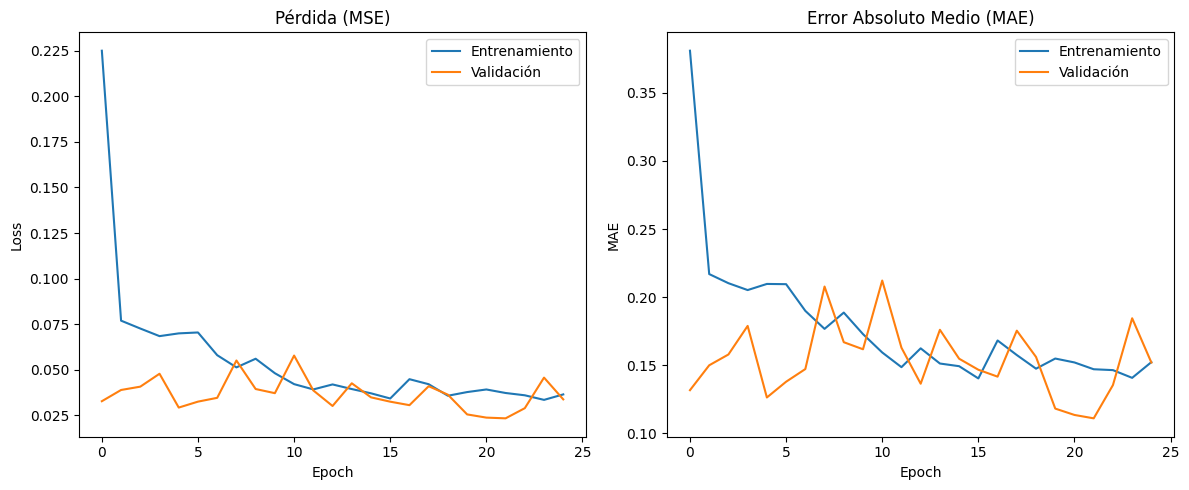

In [9]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Entrenamiento')
plt.plot(history.history['val_mae'], label='Validación')
plt.title('Error Absoluto Medio (MAE)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 94ms/step
⏱️ Tiempo de vuelta estimado (MLP) para Bahréin 2025: 00:01:33.701


C:\Users\julia\AppData\Local\Temp\ipykernel_15876\1434568644.py:40: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from current font.
  plt.tight_layout()
D:\Anaconda\envs\neuralEnv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


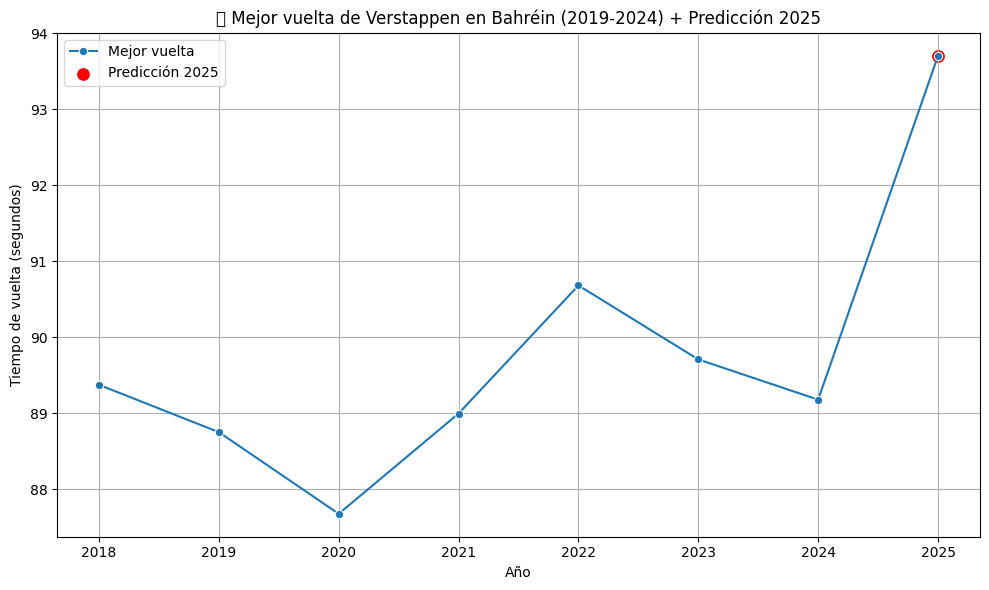

In [10]:
# Usamos las últimas 10 vueltas como input
last_50_laps = lap_times_scaled[-50:].flatten().reshape(1, -1)

predicted_scaled = mlp_model.predict(last_50_laps)
predicted_time = scaler.inverse_transform(predicted_scaled)[0][0]

def seconds_to_time_str(seconds):
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    secs = seconds % 60
    return f"{hours:02}:{minutes:02}:{secs:06.3f}"

print(f"⏱️ Tiempo de vuelta estimado (MLP) para Bahréin 2025: {seconds_to_time_str(predicted_time)}")

# Usamos directamente la columna numérica (en segundos)
data_plot = data.copy()

# Obtener la mejor vuelta por año
best_laps_by_year = data_plot.groupby('Year')['LapTime'].min().reset_index()

# Agregar la predicción para 2025
predicted_row = pd.DataFrame({
    'Year': [2025],
    'LapTime': [predicted_time]  # Este debe estar en segundos (float)
})

# Unir con los datos históricos
best_laps_with_prediction = pd.concat([best_laps_by_year, predicted_row], ignore_index=True)

plt.figure(figsize=(10, 6))
sns.lineplot(data=best_laps_with_prediction, x='Year', y='LapTime', marker='o', label='Mejor vuelta')
sns.scatterplot(x=[2025], y=[predicted_time], color='red', s=100, label='Predicción 2025')

plt.title("⏱️ Mejor vuelta de Verstappen en Bahréin (2019-2024) + Predicción 2025")
plt.xlabel("Año")
plt.ylabel("Tiempo de vuelta (segundos)")
plt.xticks(best_laps_with_prediction['Year'])
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()